In [81]:
#DATA OBTAINED FROM 
#https://catalog.data.gov/dataset/consumer-complaint-database
#INSPIRED FROM 
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [82]:
#PROBLEM FORMULATION
#The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning 
#methods are best suited to solve it.
#Given a new complaint comes in, we want to assign it to one of 12 categories.

In [83]:
#PART 01 :
#DATA EXPLORATION 
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/14,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/14,Closed with explanation,Yes,No,759217
1,10/1/16,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/16,Closed with explanation,Yes,No,2141773
2,10/17/16,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/16,Closed with explanation,Yes,No,2163100
3,6/8/14,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/14,Closed with explanation,Yes,Yes,885638
4,9/13/14,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/14,Closed with explanation,Yes,Yes,1027760


In [84]:
#check shape 
df.shape

(9999, 18)

In [85]:
#PART 02 
#INPUT OUTPUT SEGREGATION 
#For this project, we need only two columns — “Product” and “Consumer complaint narrative”.
#Input: Consumer_complaint_narrative
#Output:Product

In [86]:
#PART 03 
#DATA CLEANING 

In [87]:
#remove all column except input and output 
col = ['Product', 'Consumer Complaint']
df= df[col]
#remove null review comments 
df= df[pd.notnull(df['Consumer Complaint'])]
#rename the column from Consumer Complaint to Consumer_complaint
df.columns=['Product', 'Consumer_complaint']
#factorize the product and rename with categoryid 
df['category_id'] = df['Product'].factorize()[0]
#remove duplicates 
df=df.drop_duplicates()


In [88]:
df.head()

,Product,Consumer_complaint,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


In [89]:
print(df.shape)

(2110, 3)


In [90]:
#preserve mapping of product to category id mapping 
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

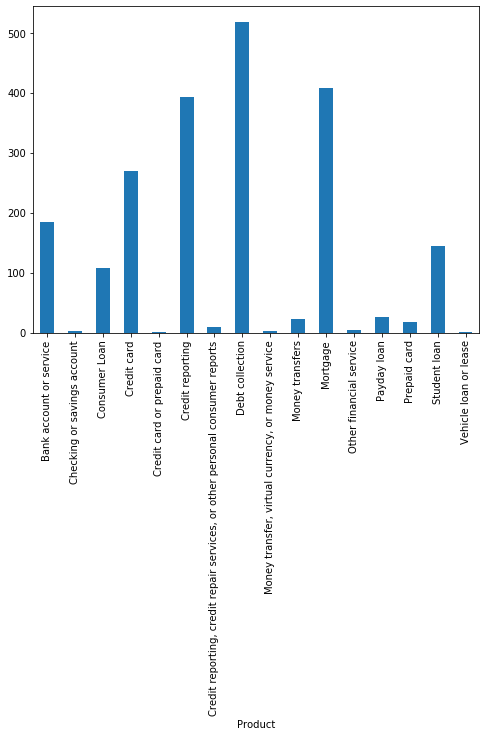

In [91]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint.count().plot.bar(ylim=0)
plt.show()

In [92]:
#see number of different category id available 
df['category_id'].value_counts()
#we have 16 categories 

2     518
3     407
0     392
4     270
6     185
7     145
1     108
9      26
8      22
10     18
12      9
5       4
13      2
11      2
15      1
14      1
Name: category_id, dtype: int64

In [93]:
#remove product id 
# df =df.drop(df.loc[:,['Product']], axis =1 )
# df.head()

In [94]:
#now our df is ready #now we will go for Text Processig 
#PART -04 
#TEXT PROCESSING 
# One common approach for extracting features from text is to use the bag of words model:
#     a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words
#     is taken into consideration, but the order in which they occur is ignored.

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf= True, #use a logarithmic form for frequency
                       min_df = 5, #minimum numbers of documents a word must be present in to be kept
                       norm= 'l2', #ensure all our feature vectors have a euclidian norm of 1
                       ngram_range= (1,2), #to indicate that we want to consider both unigrams and bigrams.
                       stop_words ='english') #to remove all common pronouns to reduce the number of noisy features
features = tfidf.fit_transform(df.Consumer_complaint).toarray()
labels = df.category_id

In [96]:
#Details of TFIDF vectorization 
# We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:
# ->sublinear_df is set to True to use a logarithmic form for frequency.
# ->min_df is the minimum numbers of documents a word must be present in to be kept.
# ->norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ->ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
# ->stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [97]:
print(df.shape)
print(features.shape)

(2110, 3)
(2110, 6069)


In [98]:
#now we know that in tfidf our data will be projected to 6069 columns 

In [99]:
#multiclass classifier 
#lets start with  linear SVM 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint'], df['category_id'], random_state= 0,test_size=0.2)
X_train_tfidf = tfidf.fit_transform(X_train)
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X_train_tfidf, y_train)
y_test

7386    3
780     4
6882    0
886     4
8037    2
       ..
9468    6
3856    2
676     2
4319    2
8084    4
Name: category_id, Length: 422, dtype: int64

In [100]:
print(clf.predict(tfidf.transform(['I have outdated information on my credit repor'])))

[0]


In [101]:
from sklearn import metrics
y_pred = clf.predict(tfidf.transform(X_test))
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73        68
           1       0.78      0.41      0.54        17
           2       0.73      0.85      0.79        98
           3       0.86      0.92      0.89        91
           4       0.78      0.72      0.75        58
           5       0.00      0.00      0.00         1
           6       0.72      0.76      0.74        41
           7       1.00      0.80      0.89        30
           8       0.00      0.00      0.00         4
           9       1.00      0.29      0.44         7
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         3

    accuracy                           0.77       422
   macro avg       0.50      0.43      0.44       422
weighted avg       0.76      0.77      0.76       422



C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7748815165876777

In [103]:
#so we are getting accuracy of 77% in case of linear SVM 


In [104]:
#MODEL SELECTION 
# We will benchmark the following four models:
# Logistic Regression
# (Multinomial) Naive Bayes
# Linear Support Vector Machine
# Random Forest

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)

In [106]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.469194
1,RandomForestClassifier,1,0.473934
2,RandomForestClassifier,2,0.445498
3,RandomForestClassifier,3,0.490521
4,RandomForestClassifier,4,0.431280
5,LinearSVC,0,0.812796
6,LinearSVC,1,0.810427
7,LinearSVC,2,0.796209
8,LinearSVC,3,0.810427
9,LinearSVC,4,0.774882


In [107]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.800948
LogisticRegression        0.769668
MultinomialNB             0.676303
RandomForestClassifier    0.462085
Name: accuracy, dtype: float64

In [108]:
#NOW LETS DO SAMETHING USING NTLTK 


In [109]:
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
#remove all column except input and output 
col = ['Product', 'Consumer Complaint']
df= df[col]
#remove null review comments 
df= df[pd.notnull(df['Consumer Complaint'])]
#rename the column from Consumer Complaint to Consumer_complaint
df.columns=['Product', 'Consumer_complaint']
#factorize the product and rename with categoryid 
df['category_id'] = df['Product'].factorize()[0]
#remove duplicates 
#remove product id 
df =df.drop(df.loc[:,['Product']], axis =1 )
df=df.drop_duplicates()

df.head()

,Consumer_complaint,category_id
1,I have outdated information on my credit repor...,0
2,I purchased a new car on XXXX XXXX. The car de...,1
7,An account on my credit report has a mistaken ...,0
12,This company refuses to provide me verificatio...,2
16,This complaint is in regards to Square Two Fin...,2


In [110]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [111]:
def clean_text(df):
    all_reviews = list()
    lines = df["Consumer_complaint"].values.tolist()
    for text in lines:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        words=nltk.word_tokenize(text)
        stop_words= set(stopwords.words('english'))
        stop_words.discard("not")
        words_without_stop_words=[word for word in words if word not in stop_words]
        #words=[lemmatizer.lemmatize(word) for word in words_without_stop_words ]
        words=[ps.stem(word) for word in words_without_stop_words ]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

all_complaint = clean_text(df)
all_complaint[0:20]  
#print(len(all_complaint))

['outdat inform credit report previous disput yet remov inform seven year old not meet credit report requir',
 'purchas new car xxxx xxxx car dealer call citizen bank get day payoff loan good till xxxx xxxx dealer sent check next day balanc checkbook xxxx xxxx notic citizen bank taken automat payment check account xxxx xxxx xxxx bank call citizen state not close loan xxxx xxxx state not receiv check xxxx xxxx told not believ check took long arriv xxxx told check issu amount overpaid deduct addit interest today xxxx xxxx call citizen bank talk supervisor name xxxx xxxx xxxx receiv letter loan paid full date xxxx xxxx refund check includ xxxx state hold payment busi day loan satisfi check would mail wed xx xx xxxx question delay post dealer payment first state sometim take busi day post said not receiv check till xxxx xxxx told not believ ask money state hold payment busi day ask simpli said polici ask would receiv interest money state believ citizen bank deliber delay post payment retur

In [112]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
TV = TfidfVectorizer(sublinear_tf= True, #use a logarithmic form for frequency
                       min_df = 5, #minimum numbers of documents a word must be present in to be kept
                       norm= 'l2', #ensure all our feature vectors have a euclidian norm of 1
                       ngram_range= (1,2))   
X = TV.fit_transform(all_complaint).toarray()
y = df.as_matrix(["category_id"])
print(np.shape(X))
print(np.shape(y))

(2110, 6739)
(2110, 1)


C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [113]:
print(X[0])
print(len(X[0]))

[0. 0. 0. ... 0. 0. 0.]
6739


In [114]:
y[0]

array([0], dtype=int64)

In [115]:
#try linear SVC 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8175355450236966

In [116]:
#do individuaal prediction 
print(clf.predict(TV.transform(['I have outdated information on my credit report'])))

[0]


# DO SAMETHING USING SPACY 

In [117]:
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
#remove all column except input and output 
col = ['Product', 'Consumer Complaint']
df= df[col]
#remove null review comments 
df= df[pd.notnull(df['Consumer Complaint'])]
#rename the column from Consumer Complaint to Consumer_complaint
df.columns=['Product', 'Consumer_complaint']
#factorize the product and rename with categoryid 
df['category_id'] = df['Product'].factorize()[0]
#remove duplicates 
#remove product id 
df =df.drop(df.loc[:,['Product']], axis =1 )
df=df.drop_duplicates()

df.head()

,Consumer_complaint,category_id
1,I have outdated information on my credit repor...,0
2,I purchased a new car on XXXX XXXX. The car de...,1
7,An account on my credit report has a mistaken ...,0
12,This company refuses to provide me verificatio...,2
16,This complaint is in regards to Square Two Fin...,2


In [118]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import  spacy
#load english language
nlp = spacy.load('en_core_web_sm')

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [119]:
def clean_text(df):
    all_reviews = list()
    lines = df["Consumer_complaint"].values.tolist()
    for text in lines:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        #words=nltk.word_tokenize(text)
        # Creating our token object, which is used to create documents with linguistic annotations.
        words = parser(text)
        words = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]

        # Removing stop words
        words = [ word for word in words if word not in stop_words and word not in punctuations ]


        #words = ''.join(str(words))
        #words = ' '.join(str(words))
        all_reviews.append(words)
        
    return all_reviews

all_complaint = clean_text(df)
all_complaint = [" ".join(item) for item in all_complaint]
all_complaint[0:20]  

['outdate information credit report previously dispute remove information seven year old doe meet credit report requirement',
 'purchase new car xxxx xxxx car dealer citizen bank day payoff loan good till xxxx xxxx dealer send check day balance checkbook xxxx xxxx notice citizen bank automatic payment check account xxxx xxxx xxxx bank citizen state close loan xxxx xxxx state receive check xxxx xxxx tell believe check long arrive xxxx tell check issue overpay deduct additional interest today xxxx xxxx citizen bank talk supervisor xxxx xxxx xxxx receive letter loan pay date xxxx xxxx refund check include xxxx state hold payment business day loan satisfy check mail xx xx xxxx question delay post dealer payment \ufeff1 state business day post receive check till xxxx xxxx tell believe ask money state hold payment business day ask simply policy ask receive interest money state believe citizen bank deliberately delay post payment return consumer s money additional interest bank illegal doe hu

In [120]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
TV = TfidfVectorizer(sublinear_tf= True, #use a logarithmic form for frequency
                       min_df = 5, #minimum numbers of documents a word must be present in to be kept
                       norm= 'l2', #ensure all our feature vectors have a euclidian norm of 1
                       ngram_range= (1,2))   
X = TV.fit_transform(all_complaint).toarray()
y = df.as_matrix(["category_id"])
print(np.shape(X))
print(np.shape(y))

(2110, 5572)
(2110, 1)


C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [121]:
#try linear SVC 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

C:\Users\INE12363221\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8080568720379147

In [122]:
#do individuaal prediction 
print(clf.predict(TV.transform(['I have outdated information on my credit report'])))

[0]
